<a href="https://colab.research.google.com/github/natanascimento/big-data-analysis/blob/main/credit-risk/notebooks/%5BBig_Data%5D_Quero_Empr%C3%A9stimo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importação de dependências

In [1]:
import warnings

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from imblearn.combine import SMOTEENN

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_validate

from sklearn.feature_selection import RFECV

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import precision_recall_curve, roc_auc_score
from sklearn.metrics import plot_roc_curve, plot_confusion_matrix

from pandasql import sqldf

In [2]:
# Filtrando tipos de avisos para serem ignorados

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Dicionário de dados

In [3]:
columns_desc = [["CHEQUEESPECIAL", "Valor que o cliente possui em cheque especial. 0 <= x < 200 indica entre 1 e 199 reais, por exemplo"], 
                ["USO_CREDITO" , "Tempo, em meses, que o cliente usa o crédito"], 
                ["HISTORICO_CREDITO", "Observação do histórico de crédito"], 
                ["PROPOSITO", "Propósito do empréstimo"], 
                ["BALANCO_ATUAL", "Saldo do cliente"], 
                ["BALANCO_MEDIO_CREDITO", "Bônus que o cliente possui (R$)"], 
                ["EMPREGADO", "Quantidade de anos que o cliente está empregado"], 
                ["LOCAL", "Código da localização do cliente"], 
                ["ESTADOCIVIL", "Estado civil do cliente"], 
                ["OUTRASFUNCOES", "Outras funções do crédito"], 
                ["RESIDENCIADESDE", "Há quantos anos o cliente possui residência fixa"], 
                ["TIPOSBENS", "Tipos de bens"], 
                ["IDADE", "Idade"], 
                ["OUTROSPLANOSPGTO", "Outros planos de pagamento"], 
                ["RESIDENCIA", "Qual é a forma de residência"], 
                ["CREDITOSEXISTENTES", "Quantidade de contratos que o cliente possui"], 
                ["EMPREGO", "Modalidade de emprego que o cliente se enquadra"], 
                ["DEPENDENTES", "Número de dependentes"], 
                ["TRABAESTRANGEIRO", "Indicativo se o cliente trabalha em empresa estrangeira"], 
                ["CLASSE", "Classificação do cliente (segundo especialista): Bom ou Ruim"]]

In [4]:
data_dict = pd.DataFrame(columns_desc, columns=["variável", "descrição"])

In [5]:
data_dict

,variável,descrição
0,CHEQUEESPECIAL,Valor que o cliente possui em cheque especial....
1,USO_CREDITO,"Tempo, em meses, que o cliente usa o crédito"
2,HISTORICO_CREDITO,Observação do histórico de crédito
3,PROPOSITO,Propósito do empréstimo
4,BALANCO_ATUAL,Saldo do cliente
5,BALANCO_MEDIO_CREDITO,Bônus que o cliente possui (R$)
6,EMPREGADO,Quantidade de anos que o cliente está empregado
7,LOCAL,Código da localização do cliente
8,ESTADOCIVIL,Estado civil do cliente
9,OUTRASFUNCOES,Outras funções do crédito


# Carregando ***dataset*** do ***datalake***

In [6]:
raw_data_url = "https://raw.githubusercontent.com/natanascimento/big-data-analysis/main/credit-risk/datalake/raw/rw_credit.csv"

In [7]:
dataset = pd.read_csv(raw_data_url, sep=";", encoding="cp1252")
test = pd.read_csv(raw_data_url, sep=";", encoding="cp1252")[800:]

# Análise Exploratória de Dados

Analisando as características do dataset como um todo

In [8]:
dataset.head()

,CHEQUEESPECIAL,USO_CREDITO,HISTORICO_CREDITO,PROPOSITO,BALANCO_ATUAL,BALANCO_MEDIO_CREDITO,EMPREGADO,LOCAL,ESTADOCIVIL,OUTRASFUNCOES,RESIDENCIADESDE,TIPOSBENS,IDADE,OUTROSPLANOSPGTO,RESIDENCIA,CREDITOSEXISTENTES,EMPREGO,DEPENDENTES,TRABAESTRANGEIRO,CLASSE
0,<0,6,crítica / outros de crédito existente,Computador/TV,1169,nenhuma economia conhecida,>=7,4,masculino solteiro,nenhum,4,bens imóveis,67,nenhum,própria,2,especializado,1,sim,bom
1,0<=X<200,48,existente e pago,Computador/TV,5951,<100,1<=X<4,2,fem div/cas,nenhum,2,bens imóveis,22,nenhum,própria,1,especializado,1,sim,ruim
2,sem cheque,12,crítica / outros de crédito existente,educação,2096,<100,4<=X<7,2,masculino solteiro,nenhum,3,bens imóveis,49,nenhum,própria,1,não especializado,2,sim,bom
3,<0,42,existente e pago,mobilia/equipamento,7882,<100,4<=X<7,2,masculino solteiro,fiador,4,seguro de vida,45,nenhum,gratuitamente,1,especializado,2,sim,bom
4,<0,24,atrasos anteriores,carro novo,4870,<100,1<=X<4,3,masculino solteiro,nenhum,4,nenhuma conhecida,53,nenhum,gratuitamente,2,especializado,2,sim,ruim


In [9]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   CHEQUEESPECIAL         1000 non-null   object
 1   USO_CREDITO            1000 non-null   int64 
 2   HISTORICO_CREDITO      1000 non-null   object
 3   PROPOSITO              1000 non-null   object
 4   BALANCO_ATUAL          1000 non-null   int64 
 5   BALANCO_MEDIO_CREDITO  1000 non-null   object
 6   EMPREGADO              1000 non-null   object
 7   LOCAL                  1000 non-null   int64 
 8   ESTADOCIVIL            1000 non-null   object
 9   OUTRASFUNCOES          1000 non-null   object
 10  RESIDENCIADESDE        1000 non-null   int64 
 11  TIPOSBENS              1000 non-null   object
 12  IDADE                  1000 non-null   int64 
 13  OUTROSPLANOSPGTO       1000 non-null   object
 14  RESIDENCIA             1000 non-null   object
 15  CREDITOSEXISTENTES    

In [10]:
dataset.describe()

,USO_CREDITO,BALANCO_ATUAL,LOCAL,RESIDENCIADESDE,IDADE,CREDITOSEXISTENTES,DEPENDENTES
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,20.903000,3271.258000,2.973000,2.845000,35.546000,1.407000,1.155000
std,12.058814,2822.736876,1.118715,1.103718,11.375469,0.577654,0.362086
min,4.000000,250.000000,1.000000,1.000000,19.000000,1.000000,1.000000
25%,12.000000,1365.500000,2.000000,2.000000,27.000000,1.000000,1.000000
50%,18.000000,2319.500000,3.000000,3.000000,33.000000,1.000000,1.000000
75%,24.000000,3972.250000,4.000000,4.000000,42.000000,2.000000,1.000000
max,72.000000,18424.000000,4.000000,4.000000,75.000000,4.000000,2.000000


## Análise Univariada

### **Como está a distribuição de clientes com classe boa e ruim?**

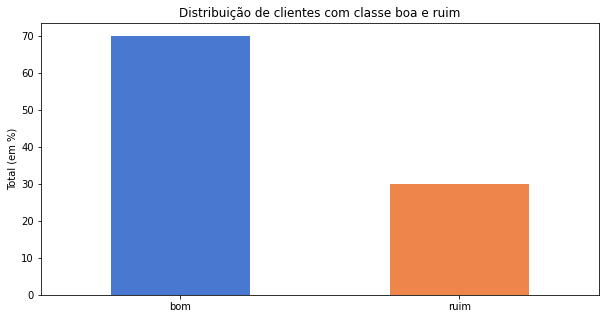

In [11]:
plt.figure(figsize=(10,5))
plt.ylabel("Total (em %)")
plt.yticks(np.arange(0, 100, step=10))
plt.title("Distribuição de clientes com classe boa e ruim")

(dataset.CLASSE.value_counts(normalize=True, sort=False)*100) \
  .plot.bar(color=sns.color_palette('muted'))

plt.xticks(rotation="horizontal")

plt.show()

Podemos identificar que que as classes estão bem desbalanceadas, onde 70% dos clientes não são inadimplementes, o que já era de se esperar 😊

### **Como está a distribuição do histórico de crédito?**

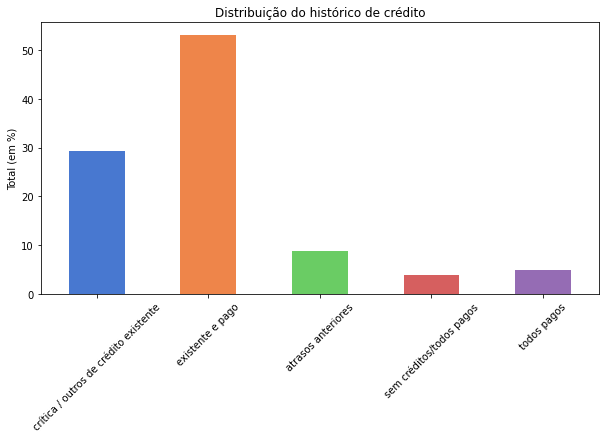

In [12]:
plt.figure(figsize=(10,5))
plt.ylabel("Total (em %)")
plt.yticks(np.arange(0, 100, step=10))
plt.title("Distribuição do histórico de crédito")

(dataset.HISTORICO_CREDITO.value_counts(normalize=True, sort=False)*100) \
  .plot.bar(color=sns.color_palette('muted'))

plt.xticks(rotation=45)

plt.show()

### **Quantos clientes estão no cheque especial?**

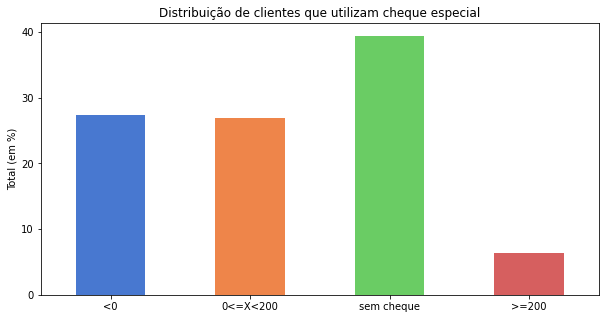

In [13]:
plt.figure(figsize=(10,5))
plt.ylabel("Total (em %)")
plt.yticks(np.arange(0, 100, step=10))
plt.title("Distribuição de clientes que utilizam cheque especial")

(dataset.CHEQUEESPECIAL.value_counts(normalize=True, sort=False)*100) \
  .plot.bar(color=sns.color_palette('muted'))

plt.xticks(rotation="horizontal")

plt.show()

### **Distribuição de clientes que trabalham em empresas estrangeiras**

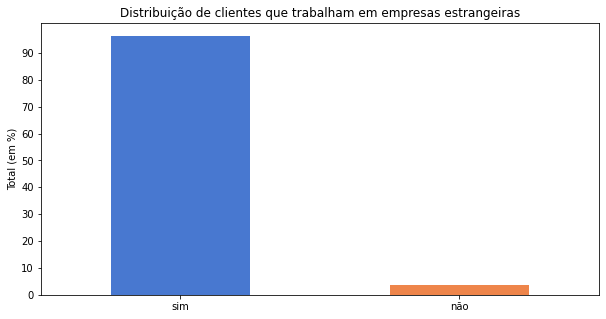

In [14]:
plt.figure(figsize=(10,5))
plt.ylabel("Total (em %)")
plt.yticks(np.arange(0, 100, step=10))
plt.title("Distribuição de clientes que trabalham em empresas estrangeiras")

(dataset.TRABAESTRANGEIRO.value_counts(normalize=True, sort=False)*100) \
  .plot.bar(color=sns.color_palette('muted'))

plt.xticks(rotation="horizontal")

plt.show()

## Análise Bivariada

### Número de créditos existentes pela idade

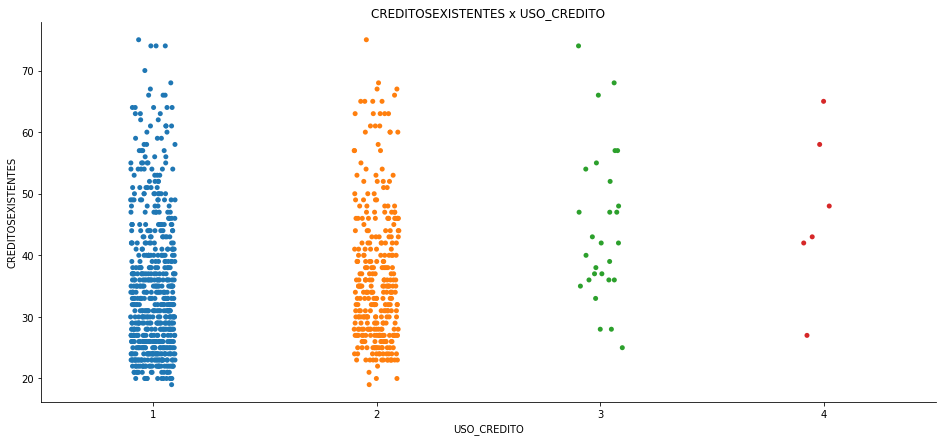

In [15]:
sns.catplot(y="IDADE", x="CREDITOSEXISTENTES", data=dataset, height=6, aspect=2.2)

plt.title("CREDITOSEXISTENTES x USO_CREDITO")
plt.xlabel("USO_CREDITO")
plt.ylabel("CREDITOSEXISTENTES")

plt.show()

### Número de dependentes pela idade

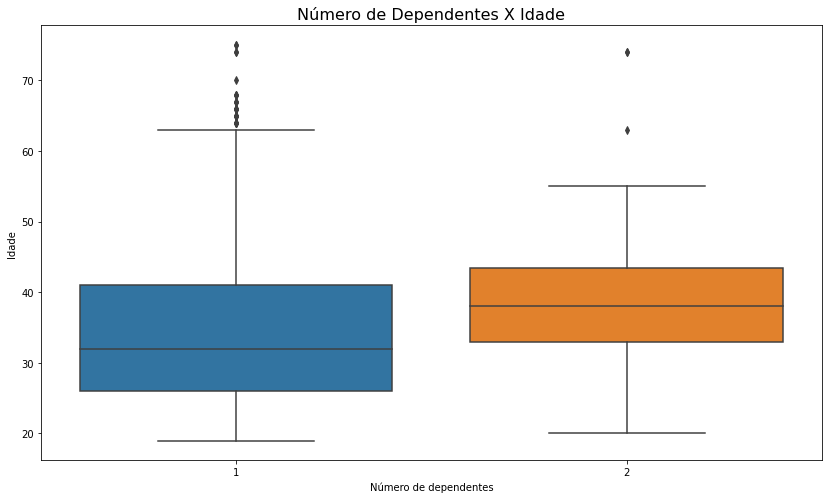

In [16]:
fig, ax = plt.subplots(figsize=(14, 8))

sns.boxplot(x='DEPENDENTES', y='IDADE', data=dataset)

plt.title('Número de Dependentes X Idade', fontsize=16)
ax.set_xticklabels([1, 2])
ax.set_xlabel('Número de dependentes')
ax.set_ylabel('Idade')
ax.set_yticks(np.arange(20, 80, 10))

plt.show()

## Análise Multivariada

### Matriz de correlação entre todas as variáveis

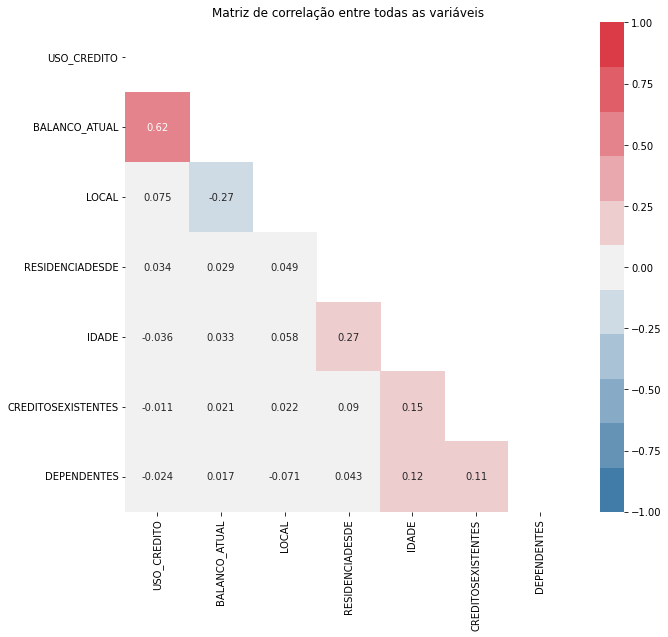

In [17]:
plt.figure(figsize=(10,9))
plt.title("Matriz de correlação entre todas as variáveis")

matriz_correlacao = dataset.corr()
mask = np.triu(np.ones_like(matriz_correlacao, dtype=bool))

sns.heatmap(matriz_correlacao, cmap = sns.diverging_palette(240, 10, n=11), vmin=-1, annot=True, vmax=1, mask=mask)

plt.show()

# Pré-Processamento

## Normalizando Dataset

In [18]:
def normalize(dataset):
  dataset["CHEQUEESPECIAL"] = dataset["CHEQUEESPECIAL"].replace("sem cheque", 1)
  dataset["CHEQUEESPECIAL"] = dataset["CHEQUEESPECIAL"].replace("<0", 2)
  dataset["CHEQUEESPECIAL"] = dataset["CHEQUEESPECIAL"].replace("0<=X<200", 3)
  dataset["CHEQUEESPECIAL"] = dataset["CHEQUEESPECIAL"].replace(">=200", 4)

  dataset["HISTORICO_CREDITO"] = dataset["HISTORICO_CREDITO"].replace("todos pagos", 5)
  dataset["HISTORICO_CREDITO"] = dataset["HISTORICO_CREDITO"].replace("sem créditos/todos pagos", 4)
  dataset["HISTORICO_CREDITO"] = dataset["HISTORICO_CREDITO"].replace("existente e pago", 3)
  dataset["HISTORICO_CREDITO"] = dataset["HISTORICO_CREDITO"].replace("crítica / outros de crédito existente", 2)
  dataset["HISTORICO_CREDITO"] = dataset["HISTORICO_CREDITO"].replace("atrasos anteriores", 1)

  dataset["BALANCO_MEDIO_CREDITO"] = dataset["BALANCO_MEDIO_CREDITO"].replace(">=1000", 5)
  dataset["BALANCO_MEDIO_CREDITO"] = dataset["BALANCO_MEDIO_CREDITO"].replace("500<=X<1000", 4)
  dataset["BALANCO_MEDIO_CREDITO"] = dataset["BALANCO_MEDIO_CREDITO"].replace("100<=X<500", 3)
  dataset["BALANCO_MEDIO_CREDITO"] = dataset["BALANCO_MEDIO_CREDITO"].replace("<100", 2)
  dataset["BALANCO_MEDIO_CREDITO"] = dataset["BALANCO_MEDIO_CREDITO"].replace("nenhuma economia conhecida", 1)

  dataset["EMPREGADO"] = dataset["EMPREGADO"].replace(">=7", 1)
  dataset["EMPREGADO"] = dataset["EMPREGADO"].replace("4<=X<7", 2)
  dataset["EMPREGADO"] = dataset["EMPREGADO"].replace("1<=X<4", 3)
  dataset["EMPREGADO"] = dataset["EMPREGADO"].replace("<1", 4)
  dataset["EMPREGADO"] = dataset["EMPREGADO"].replace("desempregado", 5)  

  dataset[["SEXO", "ESTADO_CIVIL"]] = dataset["ESTADOCIVIL"].str.split(" ", 1, expand=True)

  dataset["OUTRASFUNCOES"] = dataset["OUTRASFUNCOES"].replace("nenhum", 0)
  dataset["OUTRASFUNCOES"] = dataset["OUTRASFUNCOES"].replace("fiador", 1)
  dataset["OUTRASFUNCOES"] = dataset["OUTRASFUNCOES"].replace("co requerente", 2)

  dataset["TIPOSBENS"] = dataset["TIPOSBENS"].replace("carro", 0)
  dataset["TIPOSBENS"] = dataset["TIPOSBENS"].replace("bens imóveis", 1)
  dataset["TIPOSBENS"] = dataset["TIPOSBENS"].replace("seguro de vida", 2)
  dataset["TIPOSBENS"] = dataset["TIPOSBENS"].replace("nenhuma conhecida", 3)

  dataset["OUTROSPLANOSPGTO"] = dataset["OUTROSPLANOSPGTO"].replace("nenhum", 0)
  dataset["OUTROSPLANOSPGTO"] = dataset["OUTROSPLANOSPGTO"].replace("banco", 1)
  dataset["OUTROSPLANOSPGTO"] = dataset["OUTROSPLANOSPGTO"].replace("stores", 2)

  dataset["RESIDENCIA"] = dataset["RESIDENCIA"].replace("própria", 0)
  dataset["RESIDENCIA"] = dataset["RESIDENCIA"].replace("alugada", 1)
  dataset["RESIDENCIA"] = dataset["RESIDENCIA"].replace("gratuitamente", 2) 

  dataset["EMPREGO"] = dataset["EMPREGO"].replace("especializado", 0)
  dataset["EMPREGO"] = dataset["EMPREGO"].replace("alta qualificação/autonomo/Gerente", 1)
  dataset["EMPREGO"] = dataset["EMPREGO"].replace("não especializado", 2)
  dataset["EMPREGO"] = dataset["EMPREGO"].replace("unemp/unespecializado non res", 3)  

  dataset["CLASSE"] = dataset["CLASSE"].replace("bom", 0)
  dataset["CLASSE"] = dataset["CLASSE"].replace("ruim", 1)

  dataset["TRABAESTRANGEIRO"] = dataset["TRABAESTRANGEIRO"].replace("não", 0)
  dataset["TRABAESTRANGEIRO"] = dataset["TRABAESTRANGEIRO"].replace("sim", 1)

  dataset = dataset.drop(columns=["ESTADOCIVIL", "PROPOSITO", "SEXO", "ESTADO_CIVIL", "LOCAL", 
                                  "OUTRASFUNCOES", "RESIDENCIADESDE"])
  return dataset

In [19]:
dataset = normalize(dataset=dataset)
test = normalize(dataset=test)

## Splitando conjunto de dados em treino e teste

*   70% do ***dataset*** para treino
*   30% do ***dataset*** para teste



In [20]:
X_treino, X_teste, y_treino, y_teste = train_test_split(dataset.drop(columns="CLASSE"),
                                                    dataset.CLASSE,
                                                    test_size=0.3,
                                                    random_state=42,
                                                    stratify=dataset.CLASSE)

### Dimensionamento das features

In [21]:
print(f'Dimensão do conjunto de treino: {X_treino.shape}')
print(f'Dimensão do conjunto de validação: {X_teste.shape}')

print(f'Proporção da variável target no Treino: {y_treino.value_counts(normalize=True).tolist()}')
print(f'Proporção da variável target na Validação: {y_teste.value_counts(normalize=True).tolist()}')

Dimensão do conjunto de treino: (700, 14)
Dimensão do conjunto de validação: (300, 14)
Proporção da variável target no Treino: [0.7, 0.3]
Proporção da variável target na Validação: [0.7, 0.3]


## Entendendo features presentes no dataset

In [22]:
features = list(dataset.drop(columns='CLASSE').columns)
print(f"Quantidade de features: {len(features)}")
print(f"Features: {features}")

Quantidade de features: 14
Features: ['CHEQUEESPECIAL', 'USO_CREDITO', 'HISTORICO_CREDITO', 'BALANCO_ATUAL', 'BALANCO_MEDIO_CREDITO', 'EMPREGADO', 'TIPOSBENS', 'IDADE', 'OUTROSPLANOSPGTO', 'RESIDENCIA', 'CREDITOSEXISTENTES', 'EMPREGO', 'DEPENDENTES', 'TRABAESTRANGEIRO']


## Detecção de valores faltantes

In [23]:
pd.DataFrame(data={"Treino(%)": round(X_treino.isna().mean() * 100, 2),
                   "Teste(%)": round(y_treino.isna().mean() * 100, 2)})

,Treino(%),Teste(%)
CHEQUEESPECIAL,0.0,0.0
USO_CREDITO,0.0,0.0
HISTORICO_CREDITO,0.0,0.0
BALANCO_ATUAL,0.0,0.0
BALANCO_MEDIO_CREDITO,0.0,0.0
EMPREGADO,0.0,0.0
TIPOSBENS,0.0,0.0
IDADE,0.0,0.0
OUTROSPLANOSPGTO,0.0,0.0
RESIDENCIA,0.0,0.0


## Oversamplig e Undersampling

In [24]:
smoteenn = SMOTEENN(random_state=42)

In [25]:
X_treino_balanceado, y_treino_balanceado = smoteenn.fit_resample(X_treino, y_treino)

In [26]:
print(f'Dimensão antes do SMOTEENN: {X_treino.shape}')
print(f'Dimensão depois do SMOTEENN: {X_treino_balanceado.shape}')

print(f'Proporção da variável target antes do SMOTEENN: {y_treino.value_counts(normalize=True).tolist()[0] * 100:.2f}% / {y_treino.value_counts(normalize=True).tolist()[1] * 100:.2f}%')
print(f'Proporção da variável target depois do SMOTEENN: {y_treino_balanceado.value_counts(normalize=True).tolist()[0] * 100:.2f}% / {y_treino_balanceado.value_counts(normalize=True).tolist()[1] * 100:.2f}%')

Dimensão antes do SMOTEENN: (700, 14)
Dimensão depois do SMOTEENN: (336, 14)
Proporção da variável target antes do SMOTEENN: 70.00% / 30.00%
Proporção da variável target depois do SMOTEENN: 58.33% / 41.67%


In [27]:
X_treino_balanceado.columns

Index(['CHEQUEESPECIAL', 'USO_CREDITO', 'HISTORICO_CREDITO', 'BALANCO_ATUAL',
       'BALANCO_MEDIO_CREDITO', 'EMPREGADO', 'TIPOSBENS', 'IDADE',
       'OUTROSPLANOSPGTO', 'RESIDENCIA', 'CREDITOSEXISTENTES', 'EMPREGO',
       'DEPENDENTES', 'TRABAESTRANGEIRO'],
      dtype='object')

# Modelagem Preditiva

## Baseline - Regressão Logística

In [28]:
# Definindo o modelo
model = LogisticRegression()

# Treinando e salvando resultados
resultados_lr = cross_validate(model, X_treino_balanceado, y_treino_balanceado, cv=10, scoring='roc_auc')

## Árvore de Decisão

In [29]:
# Definindo o modelo
model = DecisionTreeClassifier()

# Treinando e salvando resultados
resultados_dt = cross_validate(model, X_treino_balanceado, y_treino_balanceado, cv=10, scoring='roc_auc')

## Random Forest

In [30]:
# Definindo o modelo
model = RandomForestClassifier(n_estimators=20)

# Treinando e salvando resultados
resultados_rf = cross_validate(model, X_treino_balanceado, y_treino_balanceado, cv=10, scoring='roc_auc')

## Comparação dos modelos

In [31]:
# Adicionando a média dos scores em cada lista
resultados_lr = np.append(resultados_lr['test_score'], resultados_lr['test_score'].mean())
resultados_dt = np.append(resultados_dt['test_score'], resultados_dt['test_score'].mean())
resultados_rf = np.append(resultados_rf['test_score'], resultados_rf['test_score'].mean())

models_score = pd.DataFrame(
    index = ['Regressão Logística', 'Árvore de Decisão', 'Random Forest'],
    columns = ['Fold 1', 'Fold 2', 'Fold 3', 'Fold 4', 'Fold 5', 'Fold 6', 'Fold 7', 'Fold 8', 'Fold 9', 'Fold 10', 'Média'],
    data = [resultados_lr, resultados_dt, resultados_rf]
)

In [32]:
models_score

,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Fold 6,Fold 7,Fold 8,Fold 9,Fold 10,Média
Regressão Logística,0.685714,0.871429,0.689286,0.478571,0.764286,0.767857,0.819549,0.646617,0.511278,0.620301,0.685489
Árvore de Decisão,0.807143,0.714286,0.682143,0.682143,0.950000,0.714286,0.892857,0.706767,0.821429,0.759398,0.773045
Random Forest,0.914286,0.930357,0.769643,0.835714,0.944643,0.926786,0.968045,0.913534,0.887218,0.973684,0.906391


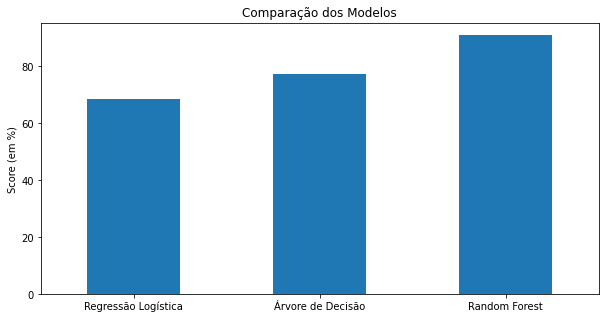

In [33]:
plt.figure(figsize=(10,5))
plt.ylabel("Score (em %)")
plt.title("Comparação dos Modelos")

(models_score["Média"]*100).plot.bar()

plt.xticks(rotation="horizontal")

plt.show()

## Seleção de variáveis

### Realizando a definição do modelo Random Forest e definindo o modelo que fará a seleção de variáveis

In [34]:
rf = RandomForestClassifier(n_estimators=20)

rfecv = RFECV(rf, cv=10, scoring='roc_auc')

In [35]:
rfecv = rfecv.fit(X_treino_balanceado, y_treino_balanceado)

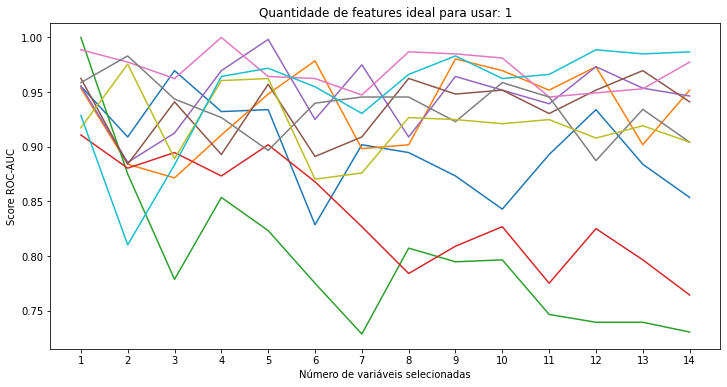

In [36]:
plt.figure(figsize=(12, 6))

plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)

plt.title(f'Quantidade de features ideal para usar: {rfecv.n_features_}')

plt.xlabel('Número de variáveis selecionadas')
plt.ylabel('Score ROC-AUC')

plt.xticks(np.arange(1, len(rfecv.grid_scores_) + 1, 1))

plt.show()

## Tunagem de Hiperparâmetros

In [37]:
model = RandomForestClassifier(min_samples_leaf=2, random_state=42)

### Definindo os hiperparâmetros que serão testados

In [38]:
params = {
    'n_estimators': [50, 100, 150, 200, 300],
    'max_features': ['sqrt', 5],
    'max_depth': [5, 10]
}

In [39]:
grid_search = GridSearchCV(
    estimator = model,
    param_grid = params,
    scoring = 'recall',
    cv = 10,
    n_jobs = 1)

In [40]:
grid_search = grid_search.fit(X_treino_balanceado, y_treino_balanceado)

In [41]:
pd.DataFrame(index=grid_search.best_params_.keys(), columns=['Melhor Valor'], data=grid_search.best_params_.values())

,Melhor Valor
max_depth,10
max_features,5
n_estimators,300


In [42]:
model = RandomForestClassifier(
    n_estimators = 50,
    min_samples_leaf = 2,
    max_depth = 5,
    max_features = 5,
    random_state = 42)

In [43]:
model = model.fit(X_treino_balanceado, y_treino_balanceado)

### Matriz de confusão com dados normalizados em relação aos labels reais

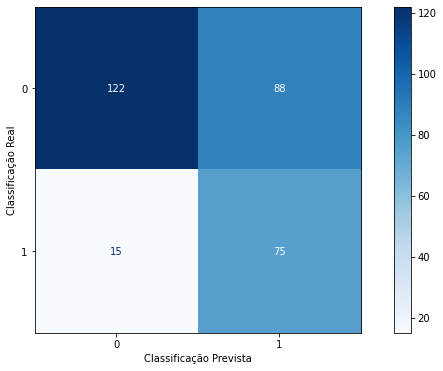

In [44]:
fig, ax = plt.subplots(figsize=(12, 6))

plot_confusion_matrix(model, X_teste, y_teste, values_format = '.0f', ax=ax, cmap='Blues')

ax.set_xlabel('Classificação Prevista')
ax.set_ylabel('Classificação Real')

plt.show()

## Avaliando o modelo

### Dentre todos os clientes que previmos serem inadimplentes, qual a taxa de acerto?

In [45]:
precisao = precision_recall_curve(y_teste, model.predict(X_teste))[0][1]

print(f"Precisao do modelo: {precisao * 100:.2f}%")

Precisao do modelo: 46.01%


### Dentre todos os clientes que realmente eram inadimplentes, qual a taxa de acerto?

In [46]:
recall = precision_recall_curve(y_teste, model.predict(X_teste))[1][1]

print(f"O Recall do modelo foi de {recall * 100:.2f}%")

O Recall do modelo foi de 83.33%


In [47]:
F1 = 2 * (precisao * recall) / (precisao + recall)

print(f"O F1 score foi de {F1 * 100:.2f}%")

O F1 score foi de 59.29%


### Qual a relação entre os Falso Positivos e Verdadeiro Positivos das nossas classificações?

In [48]:
roc_auc = roc_auc_score(y_teste, model.predict_proba(X_teste)[:, 1])

print(f'O score ROC-AUC é de: {roc_auc:.2f}')

O score ROC-AUC é de: 0.77


### Curva ROC e o score:

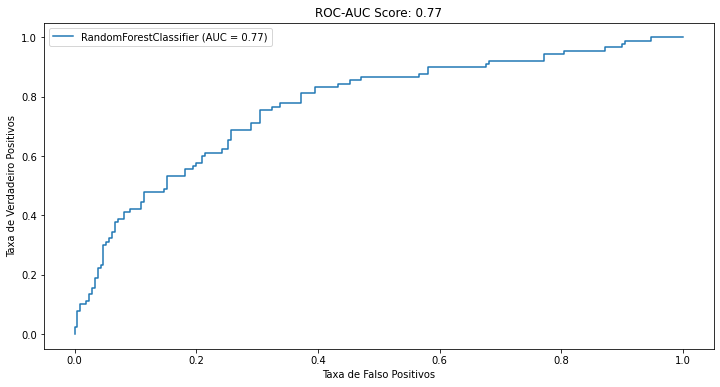

In [49]:
fig, ax = plt.subplots(figsize=(12, 6))

# Plot para o conjunto de validação
plot_roc_curve(model, X_teste, y_teste, ax=ax)

# Propriedades do gráfico
ax.set_title(f'ROC-AUC Score: {roc_auc:.2f}')

ax.set_xlabel('Taxa de Falso Positivos')
ax.set_ylabel('Taxa de Verdadeiro Positivos')

plt.legend()

plt.show()

In [50]:
resultado_teste = model.predict(dataset.drop(columns="CLASSE"))

In [51]:
proporcao = pd.Series(resultado_teste).value_counts(normalize=True) * 100

In [52]:
print(f"O modelo classificou {proporcao[1]:.2f}% inadimplentes e {proporcao[0]:.2f}% adimplentes")

O modelo classificou 53.20% inadimplentes e 46.80% adimplentes


# Validando previsões

In [53]:
test = test.drop(columns="CLASSE")

In [54]:
test.head()

,CHEQUEESPECIAL,USO_CREDITO,HISTORICO_CREDITO,BALANCO_ATUAL,BALANCO_MEDIO_CREDITO,EMPREGADO,TIPOSBENS,IDADE,OUTROSPLANOSPGTO,RESIDENCIA,CREDITOSEXISTENTES,EMPREGO,DEPENDENTES,TRABAESTRANGEIRO
800,1,24,2,1597,2,1,3,54,0,2,2,0,2,1
801,3,18,2,1795,2,1,1,48,1,1,2,2,1,1
802,2,20,2,4272,2,1,2,24,0,0,2,0,1,1
803,1,12,2,976,1,1,0,35,0,0,2,0,1,1
804,3,12,3,7472,1,5,1,24,0,1,1,3,1,1


In [55]:
resultados_teste = model.predict(test)

In [56]:
prop_teste = pd.Series(resultados_teste).value_counts(normalize=True) * 100

print(f'No conjunto de teste, '
      f'o modelo classificou {prop_teste[1]:.2f}% dos clientes como inadimplentes '
      f'e {prop_teste[0]:.2f}% como adimplentes.')

No conjunto de teste, o modelo classificou 53.50% dos clientes como inadimplentes e 46.50% como adimplentes.


In [57]:
test['INADIMPLENTE'] = resultados_teste

In [58]:
test.head()

,CHEQUEESPECIAL,USO_CREDITO,HISTORICO_CREDITO,BALANCO_ATUAL,BALANCO_MEDIO_CREDITO,EMPREGADO,TIPOSBENS,IDADE,OUTROSPLANOSPGTO,RESIDENCIA,CREDITOSEXISTENTES,EMPREGO,DEPENDENTES,TRABAESTRANGEIRO,INADIMPLENTE
800,1,24,2,1597,2,1,3,54,0,2,2,0,2,1,0
801,3,18,2,1795,2,1,1,48,1,1,2,2,1,1,1
802,2,20,2,4272,2,1,2,24,0,0,2,0,1,1,1
803,1,12,2,976,1,1,0,35,0,0,2,0,1,1,0
804,3,12,3,7472,1,5,1,24,0,1,1,3,1,1,0


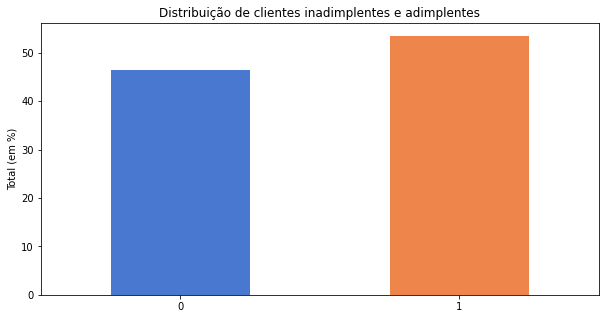

In [59]:
plt.figure(figsize=(10,5))
plt.ylabel("Total (em %)")
plt.yticks(np.arange(0, 100, step=10))
plt.title("Distribuição de clientes inadimplentes e adimplentes")

(test.INADIMPLENTE.value_counts(normalize=True, sort=False)*100) \
  .plot.bar(color=sns.color_palette('muted'))

plt.xticks(rotation="horizontal")

plt.show()

# Teste de Hipótese


## Shapiro

In [60]:
from scipy.stats import shapiro

In [61]:
for column in test.columns:
  stat, p = shapiro(test[str(column)])
  
  norm = "Normal" if p > 0.05 else "Não Normal"

  print(f'Coluna {column} é {norm} através dos valores de stat=%.25f e p=%.25f\n' % (stat, p))

Coluna CHEQUEESPECIAL é Não Normal através dos valores de stat=0.8173207044601440429687500 e p=0.0000000000000142778465510

Coluna USO_CREDITO é Não Normal através dos valores de stat=0.9259945154190063476562500 e p=0.0000000164115245837592738

Coluna HISTORICO_CREDITO é Não Normal através dos valores de stat=0.8338478803634643554687500 e p=0.0000000000000753618765699

Coluna BALANCO_ATUAL é Não Normal através dos valores de stat=0.7868455648422241210937500 e p=0.0000000000000008623468794

Coluna BALANCO_MEDIO_CREDITO é Não Normal através dos valores de stat=0.7368661165237426757812500 e p=0.0000000000000000152863126

Coluna EMPREGADO é Não Normal através dos valores de stat=0.8928866982460021972656250 e p=0.0000000000906464209249336

Coluna TIPOSBENS é Não Normal através dos valores de stat=0.8529100418090820312500000 e p=0.0000000000005966765709992

Coluna IDADE é Não Normal através dos valores de stat=0.9309332370758056640625000 e p=0.0000000400816446699536755

Coluna OUTROSPLANOSPG